## Imports

In [ ]:
# pip install sklearn
# pip install localreg
# pip install tensorflow
# pip install scipy

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer as no
from sklearn.preprocessing import normalize
import math
import pandas as pd
from localreg import *
from sklearn.neighbors import KernelDensity as dens
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import random
from scipy.stats import norm
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde as kde
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)

In [2]:
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": r"\usepackage{amsfonts}",            # load additional packages
})

## define functions

In [3]:
def Overall(Y,etaX,a):
    # Y is the vector of labels 0 or 1
    # etaX is the regression function \eta evaluated at X
    # a is the upper bound on the misclassification risk
    
    n = len(Y) # number of data points
    mrisk = np.zeros(n) # misclassification risk
    tvec = np.zeros(n) # vector of all possible thresholds
    for i,etaXi in enumerate(etaX): # calculate mrisk for each possible threshold
        if(Y[i] == 1):
            t = etaXi
        else:
            t = 1-etaXi
        # number of elements in etaX that are greater than (1-t) and have label 0
        count_1 = np.sum((etaX > (1-t)) & (Y == 0))

        # number of elements in etaX that are less than t and have label 1
        count_2 = np.sum((etaX < t) & (Y == 1))

        # mrisk
        mrisk[i] = (count_1+count_2)/n   
        
        # add threshold t to tvec
        tvec[i] = t
        
    # get index of largest element in mrisk that is <= a
    tmp = mrisk
    tmp[~(tmp <= a )] = np.iinfo(np.int32).min
    index = np.argmax(tmp)

    t = tvec[index] # optimal threshold
    mrisk = mrisk[index] # misclassification risk associated with optimal threshold (should be just less than a)
    arisk = np.sum((etaX >= t) & (etaX <= (1-t)))/n # abstention risk associated with optimal threshold
    
    return t, mrisk, arisk

In [4]:
def ClassSpecific(label, qX,a):
    # label is the label of the class (scalar: 0 or 1) that we are calculating the threshold for
    # qX ist the density quotient p1/p0 evaluated at X
    # a is the upper bound for the conditional misclassification risk P_j(f(X) = i), i != j, label = j
    
    n = len(qX) # number of data points in class
    
    if label == 0:
        t = np.sort(qX)[::-1][np.ceil(a*n).astype(int)-1] # optimal threshold t0
        mrisk = np.sum((qX > t))/n # misclassification risk associated to t0 (should be just less than a)
    else:
        t = np.sort(qX)[np.ceil(a*n).astype(int)-1]# optimal threshold t1
        mrisk = np.sum((qX < t))/n # misclassification risk associated to t1 (should be just less than a)
    
    return t, mrisk

# Example of normal distributed data

## Simulation for Section 5.1.1

#### define parameters of scenario 1

In [848]:
mu0, mu1 = 1, 0 # expected value of normal distributions of p0 and p1
sig = 1 # variance for normal distributions of p0 and p1

s = (mu0-mu1)/sig # can be considered as normalized separation parameter between p0 and p1

pi0 = 0.5 # pr(Y == 0)
pi1 = 1-pi0# pr(Y == 1)

#### plot densities p0 and p1

In [678]:
x = np.arange(-4,4,0.01)
p0 = norm.pdf(x, loc = mu0, scale = sig)
p1 = norm.pdf(x, loc = mu1, scale = sig)

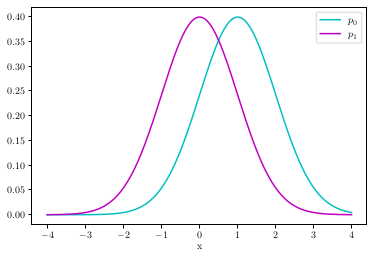

In [679]:
plt.plot(x,p0, label = r'$p_0$', color = 'c')
plt.plot(x,p1, label = r'$p_1$', color = 'm')
plt.xlabel('x')
plt.legend();
#plt.savefig('dens1.pgf');

#### plot mrisk and arisk vs t

In [680]:
t = np.arange(0.001,0.5,0.001)

# according to section 5.1.1:
a = -0.5*s-(1/s)*np.log((1-t)/t*pi0/pi1)
b = -0.5*s+(1/s)*np.log((1-t)/t*pi1/pi0)
mrisk = pi0*(norm.cdf(a))+pi1*(1-norm.cdf(b+s))
arisk = pi0*(norm.cdf(b) - norm.cdf(a))+pi1*(norm.cdf(b+s) - norm.cdf(a+s))

In [245]:
mpl.use("pgf")

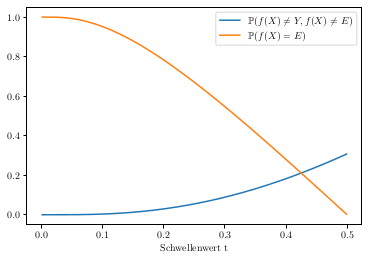

In [681]:
plt.plot(t,mrisk, label= r'$\mathbb{P}(f(X)\ne Y, f(X)\ne E)$')
plt.plot(t,arisk, label =r'$\mathbb{P}(f(X) = E)$')
plt.xlabel('Schwellenwert t')
# plt.axvline(x=0.2, color='black', ls=':')
# plt.axhline(y=mrisk[199], color='black', ls=':')
plt.legend();
#plt.savefig('1.pgf')

#### class specific case

In [937]:
t0 = np.linspace(0.001,5,1000)
t1 = np.linspace(0.001,5, 1000)

# according to section 5.1.1:
a = -0.5*s-(1/s)*np.log(t0)
b = -0.5*s-(1/s)*np.log(t1)
mrisk0 = norm.cdf(a)
mrisk1 = 1-norm.cdf(b+s)
#arisk0 = norm.cdf(b) - norm.cdf(a)
#arisk1 = norm.cdf(b+s) - norm.cdf(a+s)

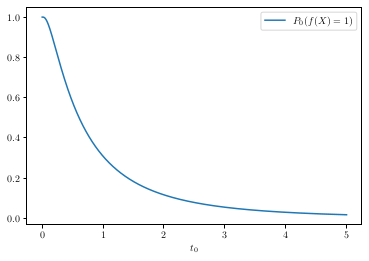

In [965]:
plt.plot(t0,mrisk0, label= r'$P_0(f(X)=1)$')
#plt.plot(t0,arisk0, label =r'$P_0(f(X) = E)$')
plt.xlabel('$t_0$')
# plt.axvline(x=0.2, color='black', ls=':')
# plt.axhline(y=mrisk[199], color='black', ls=':')
plt.legend();
plt.savefig('P_01.pgf')

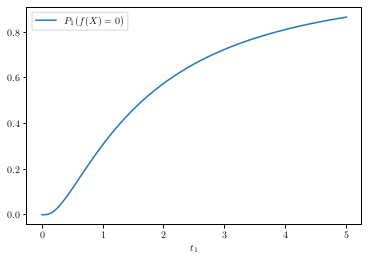

In [966]:
plt.plot(t1,mrisk1, label= r'$P_1(f(X) = 0)$')
#plt.plot(t1,arisk1, label =r'$P_1(f(X) = E)$')
plt.xlabel('$t_1$')
# plt.axvline(x=0.2, color='black', ls=':')
# plt.axhline(y=mrisk[199], color='black', ls=':')
plt.legend();
plt.savefig('P_10.pgf')

#### define parameters of scenario 2

In [682]:
mu0, mu1 = 1, -1 # expected value of normal distributions of p0 and p1
sig = 1 # variance for normal distributions of p0 and p1

s = (mu0-mu1)/sig # can be considered as normalized separation parameter between p0 and p1

pi0 = 0.5 # pr(Y == 0)
pi1 = 1-pi0# pr(Y == 1)

#### plot densities p0 and p1

In [683]:
x = np.arange(-4,4,0.01)
p0 = norm.pdf(x, loc = mu0, scale = sig)
p1 = norm.pdf(x, loc = mu1, scale = sig)

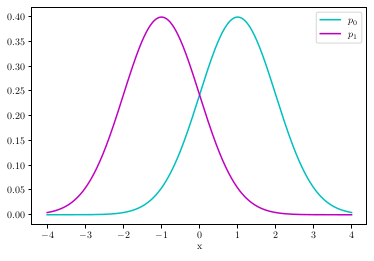

In [684]:
plt.plot(x,p0, label = r'$p_0$', color = 'c')
plt.plot(x,p1, label = r'$p_1$', color = 'm')
plt.xlabel('x')
plt.legend();
#plt.savefig('dens2.pgf');

#### plot mrisk and arisk vs t

In [685]:
t = np.arange(0.001,0.5,0.001)

# according to section 5.1.1:
a = -0.5*s-(1/s)*np.log(1/t-1)
b = -0.5*s+(1/s)*np.log(1/t-1)
mrisk = pi0*(norm.cdf(a))+pi1*(1-norm.cdf(b+s))
arisk = pi0*(norm.cdf(b) - norm.cdf(a))+pi1*(norm.cdf(b+s) - norm.cdf(a+s))

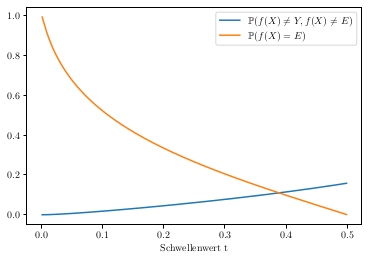

In [686]:
plt.plot(t,mrisk, label= r'$\mathbb{P}(f(X)\ne Y, f(X)\ne E)$')
plt.plot(t,arisk, label =r'$\mathbb{P}(f(X) = E)$')
plt.xlabel('Schwellenwert t')
# plt.axvline(x=0.2, color='black', ls=':')
# plt.axhline(y=mrisk[199], color='black', ls=':')
plt.legend();
#plt.savefig('1.pgf')

#### plot t vs mrisk

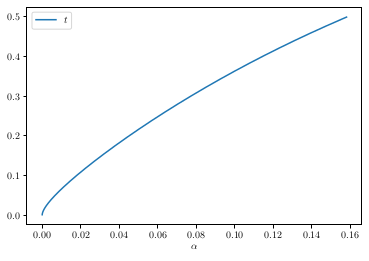

In [689]:
plt.plot(mrisk, t, label = '$t$')
plt.xlabel(r'$\alpha$')
plt.legend()

## estimation of regression function/ density quotient

#### define parameters

In [969]:
mu0, mu1 = 1, 0
sig = 1

n0, n1 =  500,500
n = n0+n1

pi0 = n0/n
pi1 = n1/n

### 1. overall (estimation of regression function)

#### define theoretical/true regression function

In [970]:
x = np.arange(-2,3,0.01)
p0 = norm.pdf(x, loc = mu0, scale = sig)
p1 = norm.pdf(x, loc = mu1, scale = sig)

etaX_true = (pi1*p1)/(pi1*p1+pi0*p0)

#### calculate estimated regression function (Scenario 1)

degree = 1, radius = 2

note: etaX ist the average of m repetitions

In [972]:
m = 1000
x = np.arange(-2,3,0.01)
etaX = np.zeros((len(x),m))

for i in range(m):
    
    (X0, Y0) = (np.random.default_rng().normal(mu0,sig,n0), np.zeros(n0))
    (X1, Y1) = (np.random.default_rng().normal(mu1,sig,n1), np.ones(n1))

    X = np.concatenate((X0,X1))
    Y = np.concatenate((Y0,Y1))

    # X = normalize(X[:,np.newaxis], axis=0).ravel()
    etaX[:,i] = localreg(X,Y,x,radius = 2, degree = 1)
    
etaX = np.mean(etaX, axis = 1)

#### plot theoretical vs. estimated regression function

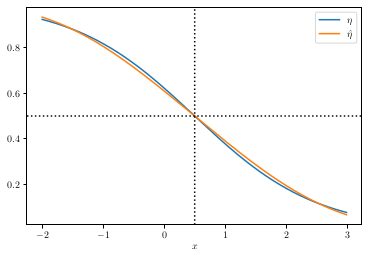

In [973]:
plt.plot(x,etaX_true, label = '$\eta$')
plt.plot(x,etaX, label = '$\hat \eta$')
plt.axvline(x=0.5, color='black', ls=':')
plt.axhline(y=0.5, color='black', ls=':')
plt.legend()
plt.xlabel('$x$');
plt.savefig('eta^_1.pgf')

#### calculate estimated regression function (Scenario 2)

degree = 2, radius = 1

note: etaX ist the average of m repetitions

In [974]:
m = 1000
x = np.arange(-2,3,0.01)
etaX = np.zeros((len(x),m))

for i in range(m):
    
    (X0, Y0) = (np.random.default_rng().normal(mu0,sig,n0), np.zeros(n0))
    (X1, Y1) = (np.random.default_rng().normal(mu1,sig,n1), np.ones(n1))

    X = np.concatenate((X0,X1))
    Y = np.concatenate((Y0,Y1))

    # X = normalize(X[:,np.newaxis], axis=0).ravel()
    etaX[:,i] = localreg(X,Y,x,radius = 1, degree = 2)
    
etaX = np.mean(etaX, axis = 1)

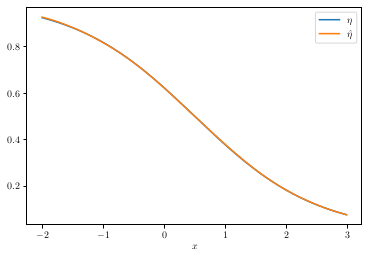

In [975]:
plt.plot(x,etaX_true, label = '$\eta$')
plt.plot(x,etaX, label = '$\hat \eta$')
# plt.axvline(x=0.5, color='black', ls=':')
# plt.axhline(y=0.5, color='black', ls=':')
plt.legend()
plt.xlabel('$x$');
#plt.savefig('eta^_2.pgf')

### 2. estimation of density quotient

#### define true density quotient

In [976]:
x = np.linspace(-2, 3, 1000)
p0_true = norm.pdf(x, loc = mu0, scale = sig)
p1_true = norm.pdf(x, loc = mu1, scale = sig)
qX_true = p1_true/p0_true

- Estimation with KernelDensity from sklearn.neighbours

In [977]:
m = 10000
x = np.linspace(-2, 3, 1000)
log_dens0 = np.zeros((len(x),m))
log_dens1 = np.zeros((len(x),m))

for i in range(m):
    
    (X0, Y0) = (np.random.default_rng().normal(mu0,sig,n0), np.zeros(n0))
    (X1, Y1) = (np.random.default_rng().normal(mu1,sig,n1), np.ones(n1))
    p0_est = dens(kernel='epanechnikov', bandwidth=1).fit(X0[:, np.newaxis])
    p1_est = dens(kernel='epanechnikov', bandwidth=1).fit(X1[:, np.newaxis])
    log_dens0[:,i] = p0_est.score_samples(x[:, np.newaxis])
    log_dens1[:,i] = p1_est.score_samples(x[:, np.newaxis])

    
log_dens0 = np.mean(log_dens0, axis = 1)
log_dens1 = np.mean(log_dens1, axis = 1)

In [978]:
p0 = np.exp(p0_est.score_samples(x[:, np.newaxis]))
p1 = np.exp(p1_est.score_samples(x[:, np.newaxis]))
qX = p1/p0

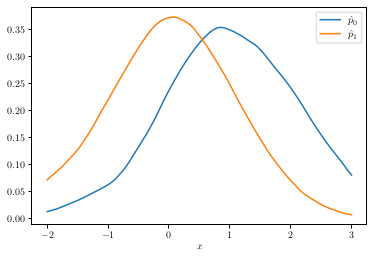

In [982]:
plt.plot(x,p0,label = r'$\hat p_0$')
plt.plot(x,p1,label = r'$\hat p_1$')
# plt.plot(x,p0_true,label = r'$p_0$')
# plt.plot(x,p1_true,label = r'$p_1$')
plt.legend()
plt.xlabel(r'$x$')
#plt.savefig('p^_1.pgf')

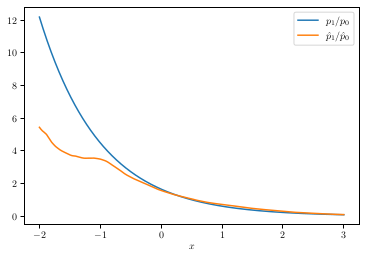

In [983]:
plt.plot(x,qX_true, label = r'$p_1/p_0$')
plt.plot(x,qX, label = r'$\hat p_1/\hat p_0$')
plt.legend()
plt.xlabel('$x$');
#plt.savefig('q^_1.pgf')

- Estimation with gaussian_kde from scipy.stats

In [984]:
m = 10000
x = np.linspace(-2, 3, 1000)
p0_estx = np.zeros((len(x),m))
p1_estx = np.zeros((len(x),m))

for i in range(m):
    
    X0 = np.random.default_rng().normal(mu0,sig,n0)
    X1 = np.random.default_rng().normal(mu1,sig,n1)
    p0_est = kde(X0.T)
    p1_est = kde(X1.T)
    #p0_est.set_bandwidth(bw_method=1)
    #p1_est.set_bandwidth(bw_method=1)
    p0_estx[:,i] = p0_est(x.T)
    p1_estx[:,i] = p1_est(x.T)

    
p0_estx = np.mean(p0_estx, axis = 1)
p1_estx = np.mean(p1_estx, axis = 1)

In [985]:
qX = p1_estx/p0_estx

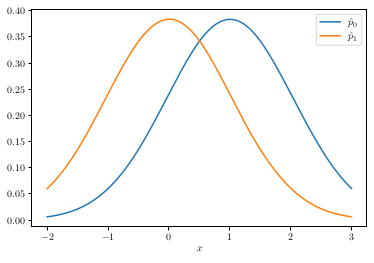

In [986]:
plt.plot(x,p0_estx,label = r'$\hat p_0$')
plt.plot(x,p1_estx,label = r'$\hat p_1$')
# plt.plot(x,p0_true,label = r'$p_0$')
# plt.plot(x,p1_true,label = r'$p_1$')
plt.legend()
plt.xlabel(r'$x$')
#plt.savefig('p^_2.pgf')

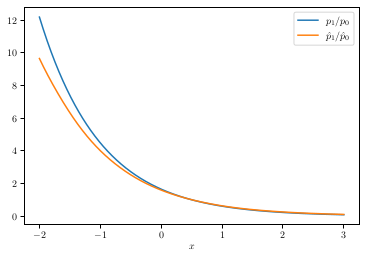

In [987]:
plt.plot(x,qX_true, label = r'$p_1/p_0$')
plt.plot(x,qX, label = r'$\hat p_1/\hat p_0$')
# plt.axvline(x=0.5, color='black', ls=':')
# plt.axhline(y=0.5, color='black', ls=':')
plt.legend()
plt.xlabel('$x$');
#plt.savefig('q^_2.pgf')

---

## Analysis of distribution of estimator

### for overall mrisk

#### define parameters of model

In [ ]:
mu0, mu1 = 1, 0
sig = 1

n0, n1 = 500,500
n = n0+n1

pi0 = n0/n
pi1 = n1/n

#### define theoretical regression function

In [993]:
m = 10000
t = np.zeros(m)
t_true = np.zeros(m)

for i in range(m):
    
    (X0, Y0) = (np.random.default_rng().normal(mu0,sig,n0), np.zeros(n0))
    (X1, Y1) = (np.random.default_rng().normal(mu1,sig,n1), np.ones(n1))

    X = np.concatenate((X0,X1))
    Y = np.concatenate((Y0,Y1))
    
    p0 = norm.pdf(X, loc = mu0, scale = sig)
    p1 = norm.pdf(X, loc = mu1, scale = sig)
    etaX_true = (pi1*p1)/(pi1*p1+pi0*p0)

    etaX = localreg(X,Y,degree = 2, radius = 1)
    t[i] = Overall(Y,etaX,0.05)[0]
    t_true[i] = Overall(Y,etaX_true,0.05)[0]

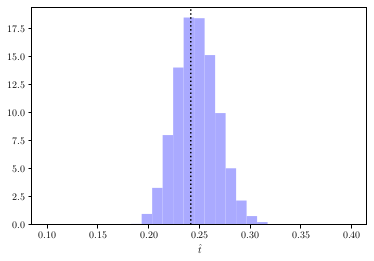

In [1003]:
bins = np.linspace(0.1, 0.4, 30)
plt.hist(t, bins=bins, fc="#AAAAFF", density = True)
plt.axvline(x=0.2415, color='black', ls=':')
#plt.legend()
plt.xlabel('$\hat t$')
#plt.savefig('t_Schaetzer.pgf')

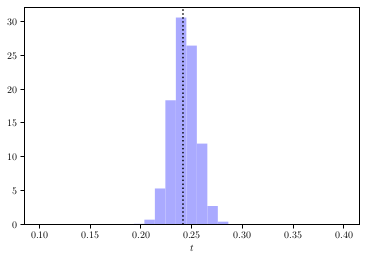

In [1004]:
bins = np.linspace(0.1, 0.4, 30)
plt.hist(t_true, bins=bins, fc="#AAAAFF", density = True)
plt.axvline(x=0.2415, color='black', ls=':')
#plt.legend()
plt.xlabel('$t$')
#plt.savefig('t_trueSchaetzer.pgf')

### class specific

In [996]:
m = 10000
t0 = np.zeros(m)
t0_true = np.zeros(m)
t1 = np.zeros(m)
t1_true = np.zeros(m)

for i in range(m):
    
    X0 = np.random.default_rng().normal(mu0,sig,n0)
    X1 = np.random.default_rng().normal(mu1,sig,n1)
    
    p0 = norm.pdf(X0, loc = mu0, scale = sig)
    p1 = norm.pdf(X0, loc = mu1, scale = sig)
    qX0_true = p1/p0
    
    p0 = norm.pdf(X1, loc = mu0, scale = sig)
    p1 = norm.pdf(X1, loc = mu1, scale = sig)
    qX1_true = p1/p0
    
    p0_est = kde(X0.T)
    p1_est = kde(X1.T)
    
    qX0 = p1_est(X0.T)/p0_est(X0.T)
    qX1 = p1_est(X1.T)/p0_est(X1.T)    

    t0[i] = ClassSpecific(0,qX0,0.05)[0]
    t0_true[i] = ClassSpecific(0,qX0_true,0.05)[0]
    t1[i] = ClassSpecific(1,qX1,0.05)[0]
    t1_true[i] = ClassSpecific(1,qX1_true,0.05)[0]

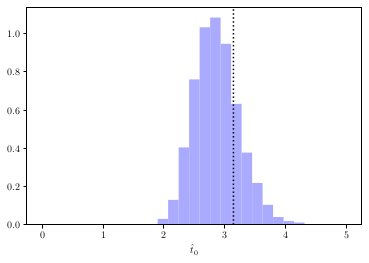

In [1005]:
bins = np.linspace(0,5, 30)
plt.hist(t0, bins=bins, fc="#AAAAFF", density = True)
plt.axvline(x=3.14164, color='black', ls=':')
#plt.legend()
plt.xlabel('$\hat t_0$')
plt.savefig('t0_Schaetzer.pgf')

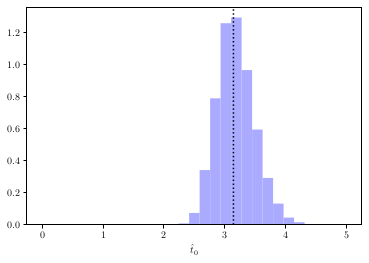

In [1006]:
bins = np.linspace(0,5, 30)
plt.hist(t0_true, bins=bins, fc="#AAAAFF", density = True)
plt.axvline(x = 3.14164, color='black', ls=':')
#plt.legend()
plt.xlabel('$\hat t_0$')
plt.savefig('t0_trueSchaetzer.pgf')

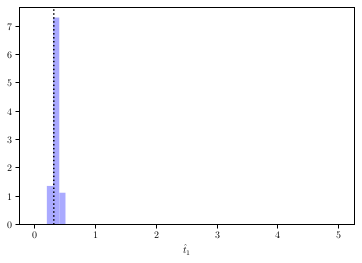

In [1010]:
bins = np.linspace(0,5, 50)
plt.hist(t1, bins=bins, fc="#AAAAFF", density = True)
plt.axvline(x=0.318, color='black', ls=':')
#plt.legend()
plt.xlabel('$\hat t_1$')
plt.savefig('t1_Schaetzer.pgf')

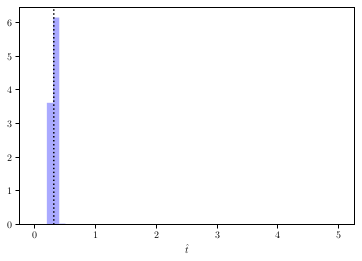

In [1009]:
bins = np.linspace(0,5, 50)
plt.hist(t1_true, bins=bins, fc="#AAAAFF", density = True)
plt.axvline(x=0.318, color='black', ls=':')
#plt.legend()
plt.xlabel('$\hat t$')
plt.savefig('t1_trueSchaetzer.pgf')

---

## unused: plots for theoretical distributions in section 5.1.3

#### define parameters

In [1011]:
mu0, mu1 = 1, 0
sig = 1
pi0 = 1/13
pi1 = 1-pi0

s = (mu0-mu1)/sig

#### plot t vs. mrisk

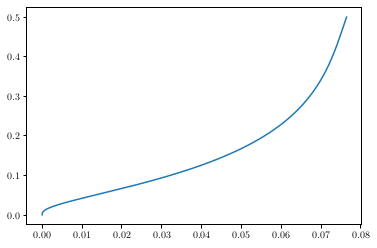

In [1014]:
plt.plot(mrisk,t)

#### plot mrisk vs. t

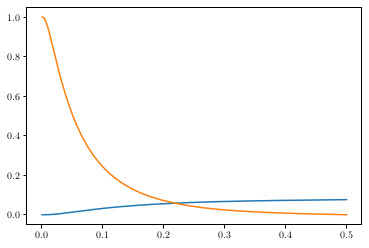

In [1013]:
t = np.arange(0.001,0.5,0.0001)
a = -0.5*s-(1/s)*np.log((1/t-1)*pi0/pi1)
b = -0.5*s+(1/s)*np.log((1/t-1)*pi1/pi0)
mrisk = pi0*(norm.cdf(a))+pi1*(1-norm.cdf(b+s))
arisk = pi0*(norm.cdf(b) - norm.cdf(a))+pi1*(norm.cdf(b+s) - norm.cdf(a+s))
plt.plot(t, mrisk)
plt.plot(t, arisk)

#### plot t vs. (cond.) missclassification risks

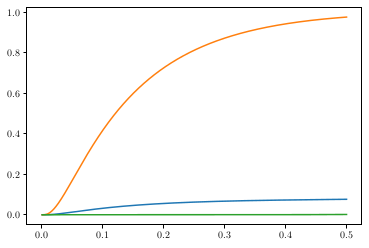

In [1015]:
mrisk0 = (norm.cdf(a))
mrisk1 = (1-norm.cdf(b+s))
mrisk = pi0*(norm.cdf(a))+pi1*(1-norm.cdf(b+s))
plt.plot(t, mrisk)
plt.plot(t, mrisk0)
plt.plot(t, mrisk1)

---

#### So far for the theoretical distributions. Now we estimate.
#### First: sample from normal distribution with parameters specified above

In [196]:
mu0, mu1 = 1, 0
sig = 1

n0, n1 = 500,6000
n = n0+n1

pi0 = n0/n
pi1 = n1/n

(X0, Y0) = (np.random.default_rng().normal(mu0,sig,n0), np.zeros(n0))
(X1, Y1) = (np.random.default_rng().normal(mu1,sig,n1), np.ones(n1))

X = np.concatenate((X0,X1))
Y = np.concatenate((Y0,Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

n0_test = len(Y_test[np.where(Y_test==0)[0]])
n1_test = len(Y_test[np.where(Y_test==1)[0]])
n_test = len(Y_test)

In [197]:
X_train0 = X_train[np.where(Y_train == 0)[0]]
X_train1 = X_train[np.where(Y_train == 1)[0]]

In [198]:
X_test0 = X_test[np.where(Y_test == 0)[0]]
X_test1 = X_test[np.where(Y_test == 1)[0]]

In [199]:
len(X_train1)

4042

### Overall

#### estimate regression function using locpol package

In [284]:
etaX_train = localreg(X_train, Y_train, degree = 2)
etaX_test = localreg(X_train, Y_train, X_test, degree = 2)

#### plot t vs mrisk

In [285]:
count_1 = np.sum((etaX_train > 0.5) & (Y_train == 0))
count_2 = np.sum((etaX_train < 0.5) & (Y_train == 1))
(count_1+count_2)/len(Y_train)   

0.07210103329506315

In [286]:
alpha = np.arange(0,0.0721,0.001)
l = len(alpha)

etaX_test0 = etaX_test[np.where(Y_test == 0)[0]] # to plot the cond. mis.risk
etaX_test1 = etaX_test[np.where(Y_test == 1)[0]] # to plot the cond. mis.risk

t = np.zeros(l)
mrisk = np.zeros(l)
mrisk0 = np.zeros(l)
mrisk1 = np.zeros(l)
arisk = np.zeros(l)
mrisk_train= np.zeros(l)

for i in range(l):
    t[i] = Overall(Y_train,etaX_train,alpha[i])[0]
    mrisk_train[i] = Overall(Y_train,etaX_train,alpha[i])[1]
    mrisk0[i] = np.sum(etaX_test0 > (1- t[i]))/n0_test
    mrisk1[i] = np.sum(etaX_test1 <  t[i])/n1_test
    mrisk[i] = (np.sum((etaX_test <  t[i]) & (Y_test == 1)) + np.sum((etaX_test > (1-t[i])) & (Y_test == 0)))/(n_test)
    arisk[i] = np.sum((etaX_test >=  t[i]) & (etaX_test <= (1-t[i])))/(n_test)

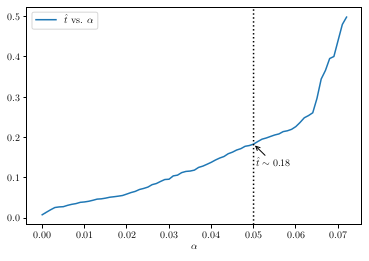

In [300]:
plt.plot(alpha,t, label = r'$\hat t$ vs. $\alpha$')
# plt.plot(t,arisk, label = r'$\mathbb{P}^{test}(f(X)= E)$')
# plt.plot(alpha,mrisk0, label = r'$P^{test}_0(f(X)=1)$')
# plt.plot(alpha,mrisk1, label = r'$P^{test}_1(f(X)=0)$')
plt.xlabel(r'$\alpha$')
#plt.ylabel(r'$\hat t$')
plt.annotate('$\hat t\sim 0.18$',xy=(0.05,0.1835488286749989),xytext=(0.0505,0.13),arrowprops=dict(arrowstyle='->'))
plt.legend()
plt.axvline(x=0.05, color='black', ls=':')
# plt.axvline(0.05, color='green', ls=':')
# plt.savefig('alphavst.pgf')

In [290]:
Overall(Y_train,etaX_train,0.05)[0]

0.1835488286749989

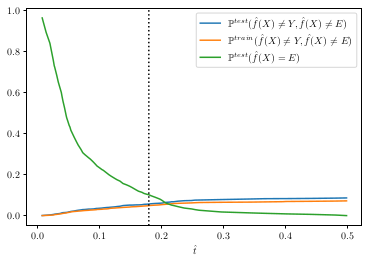

In [301]:
plt.plot(t, mrisk, label = r'$\mathbb{P}^{test}(\hat f(X)\ne Y, \hat f(X)\ne E)$')
plt.plot(t, mrisk_train, label = r'$\mathbb{P}^{train}(\hat f(X)\ne Y, \hat f(X)\ne E)$')
plt.plot(t, arisk, label = r'$\mathbb{P}^{test}(\hat f(X)= E)$')
plt.xlabel(r'$\hat t$')
plt.axvline(x=0.18, color='black', ls=':')
#plt.annotate(r'$\alpha\sim 0.06$',xy=(0.19194427896412325,0.062938),xytext=(0.21,0.13),arrowprops=dict(arrowstyle='->'))
plt.legend()
# plt.savefig('plt2.pgf')

In [292]:
np.sum((etaX_test >= 0.1835488286749989) & (etaX_test <= 1-0.1835488286749989))/len(etaX_test)

0.09696969696969697

In [293]:
(np.sum((etaX_test < 0.1835488286749989) & (Y_test == 1)) + np.sum((etaX_test > 1-0.1835488286749989) & (Y_test == 0)))/len(Y_test)

0.05780885780885781

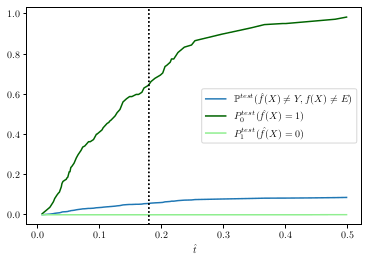

In [302]:
plt.plot(t, mrisk, label = r'$\mathbb{P}^{test}(\hat f(X)\ne Y, f(X)\ne E)$')
plt.plot(t, mrisk0, label = r'$P^{test}_0(\hat f(X)=1)$', color = 'darkgreen')
plt.plot(t, mrisk1, label = r'$P^{test}_1(\hat f(X)=0)$', color = 'lightgreen')
plt.xlabel(r'$\hat t$')
plt.axvline(x=0.18, color='black', ls=':')
plt.legend()#loc = 'upper left')
plt.axvline(x=0.18, color='black', ls=':')
# plt.savefig('plt3.pgf')

### Class specific

#### estimate density functions p0 and p1 using KernelDensity from sklearn.neighbors

In [200]:
p0_est = dens(kernel='epanechnikov', bandwidth=0.75).fit(X_train0[:, np.newaxis])
p1_est = dens(kernel='epanechnikov', bandwidth=0.75).fit(X_train1[:, np.newaxis])

#### evaluate the density-quotient estimators at the sample points

In [303]:
x = np.linspace(-6, 4, 1000)[:, np.newaxis]
log_dens0 = p0_est.score_samples(x)
log_dens1 = p1_est.score_samples(x)

Text(0.5, 0, '$x$')

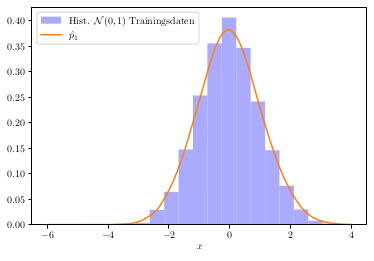

In [304]:
bins = np.linspace(-5, 4, 20)
plt.hist(X_train1, bins=bins, fc="#AAAAFF", density=True, label = 'Hist. $\mathcal N(0,1)$ Trainingsdaten')
plt.plot(x[:, 0],np.exp(log_dens1), label = r'$\hat p_1$')
plt.legend(loc = 'upper left')
plt.xlabel('$x$')
#plt.savefig('p1^.pgf')

Text(0.5, 0, '$x$')

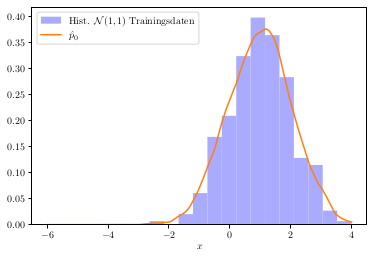

In [305]:
bins = np.linspace(-5, 4, 20)
plt.hist(X_train0, bins=bins, fc="#AAAAFF", density=True, label = 'Hist. $\mathcal N(1,1)$ Trainingsdaten')
plt.plot(x[:, 0],np.exp(log_dens0), label = r'$\hat p_0$')
plt.legend()
plt.xlabel('$x$')
#plt.savefig('p0^.pgf')

In [306]:
# p1/p0 (X_train0)
qX0_train = np.exp(p1_est.score_samples(X_train0[:, np.newaxis]))/np.exp(p0_est.score_samples(X_train0[:, np.newaxis]))
# p1/p0 (X_train1)
qX1_train = np.exp(p1_est.score_samples(X_train1[:, np.newaxis]))/np.exp(p0_est.score_samples(X_train1[:, np.newaxis]))

# p1/p0 (X_test0)
qX0_test = np.exp(p1_est.score_samples(X_test0[:, np.newaxis]))/np.exp(p0_est.score_samples(X_test0[:, np.newaxis]))
# p1/p0 (X_test1)
qX1_test = np.exp(p1_est.score_samples(X_test1[:, np.newaxis]))/np.exp(p0_est.score_samples(X_test1[:, np.newaxis]))

<ipython-input-306-152fcabec7c8>:4: RuntimeWarning: divide by zero encountered in true_divide
  qX1_train = np.exp(p1_est.score_samples(X_train1[:, np.newaxis]))/np.exp(p0_est.score_samples(X_train1[:, np.newaxis]))


Text(0.5, 0, '$x$')

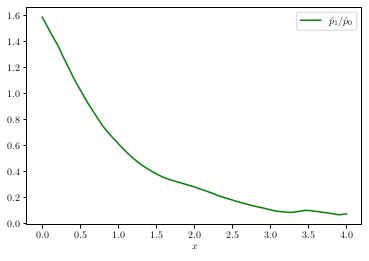

In [307]:
x = np.linspace(0, 4, 1000)[:, np.newaxis]
q = np.exp(p1_est.score_samples(x))/np.exp(p0_est.score_samples(x))
plt.plot(x,q, label = '$\hat p_1/\hat p_0$', color = 'green')
plt.legend()
plt.xlabel('$x$')
#plt.savefig('p1p0^.pgf')

In [308]:
alpha = np.linspace(0.01,0.3,1000)

l = len(alpha)
t0 = np.zeros(l)
t1 = np.zeros(l)
mrisk0 = np.zeros(l)
arisk0 = np.zeros(l)
mrisk1 = np.zeros(l)
arisk1 = np.zeros(l)

for i in range(l):
    t0[i] = ClassSpecific(0,qX0_train,alpha[i])[0]
    mrisk0[i] = np.sum(qX0_test > t0[i])/n0_test
    t1[i] = ClassSpecific(1,qX1_train,alpha[i])[0]
    mrisk1[i] = np.sum(qX1_test < t1[i])/n1_test
    arisk0[i] = np.sum((qX0_test <= t0[i]) & (qX0_test >= t1[i]))/n0_test
    arisk1[i] = np.sum((qX1_test <= t0[i]) & (qX1_test >= t1[i]))/n1_test

In [309]:
ClassSpecific(0,qX0_train,0.05)[0]

2.6089181744353

In [310]:
ClassSpecific(1,qX1_train,0.05)[0]

0.335163690823453

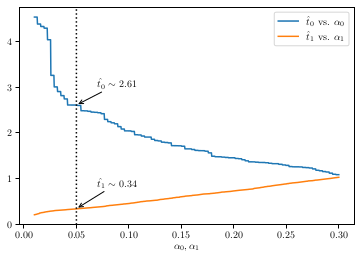

In [311]:
plt.plot(alpha,t0, label = r'$\hat t_0$ vs. $\alpha_0$')
plt.plot(alpha,t1, label = r'$\hat t_1$ vs. $\alpha_1$')
plt.xlabel(r'$\alpha_0,\alpha_1$')
plt.axvline(x=0.05, color='black', ls=':')
plt.annotate('$\hat t_0\sim$'+ ' ' + str(t0_alpha0),xy=(0.05,t0_alpha0),xytext=(0.07,3),arrowprops=dict(arrowstyle='->'))
plt.annotate('$\hat t_1\sim$' + ' ' + str(t1_alpha1),xy=(0.05,t1_alpha1),xytext=(0.07,0.82478),arrowprops=dict(arrowstyle='->'))
plt.legend()
#plt.savefig('plt4.pgf')

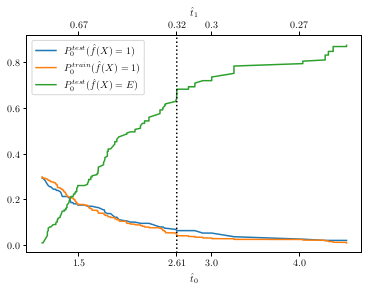

In [312]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(t0,mrisk0, label = r'$P^{test}_0(\hat f(X)=1)$')
ax1.plot(t0, alpha, label = r'$P^{train}_0(\hat f(X)=1)$')
ax1.plot(t0, arisk0, label = r'$P^{test}_0(\hat f(X)=E)$')
ax1.axvline(x=t0_alpha0, color='black', ls=':')

new_tick_locations = np.array([1.5,2.61,3,4])
idx = []

for y in new_tick_locations:
    # Prüfen, ob es einen Eintrag in X gibt, der ungefähr gleich dem aktuellen y-Wert ist
    mask = np.isclose(t0, y, rtol=0.01)
    if np.any(mask):
        # Wenn ein passender Eintrag gefunden wurde, füge den Index zur Ergebnisliste hinzu
        idx.append(np.where(mask)[0][0])
        
new = np.round(t1[idx],2)

plt.axvline(x=0.36, color='black', ls=':')
ax1.set_xlabel(r'$\hat t_0$')
ax2.set_xlabel(r'$\hat t_1$')
ax1.set_xticks(new_tick_locations)
ax1.set_xticklabels(new_tick_locations);
ax1.legend()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new);
# fig.savefig('plt5a.pgf')

In [277]:
np.sum(qX0_test > 2.6089181744353)/len(qX0_test)

0.06417112299465241

In [278]:
np.sum((qX0_test >= 0.335163690823453) & (qX0_test <= 2.6089181744353))/len(qX0_test)

0.6470588235294118

In [279]:
np.sum(qX1_test < 0.335163690823453)/len(qX1_test)

0.049029622063329927

In [280]:
np.sum((qX1_test >= 0.335163690823453) & (qX1_test <= 2.6089181744353))/len(qX1_test)

0.6894790602655771

In [264]:
(np.sum((qX0_test >= 0.335163690823453) & (qX0_test <= 2.6089181744353)) + np.sum((qX1_test >= 0.335163690823453) & (qX1_test <= 2.6089181744353)))/(len(qX0_test)+len(qX1_test))

0.6857808857808858

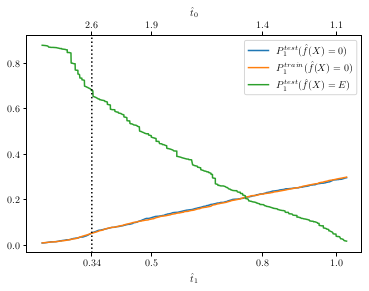

In [313]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(t1,mrisk1 ,label = r'$P^{test}_1(\hat f(X)=0)$')
ax1.plot(t1, alpha, label = r'$P^{train}_1(\hat f(X)=0)$')
ax1.plot(t1, arisk1, label = r'$P^{test}_1(\hat f(X)=E)$')

new_tick_locations = np.array([0.34,0.5,0.8,1])
idx = []
for y in new_tick_locations:
    # Prüfen, ob es einen Eintrag in X gibt, der ungefähr gleich dem aktuellen y-Wert ist
    mask = np.isclose(t1, y, rtol=0.01)
    if np.any(mask):
        # Wenn ein passender Eintrag gefunden wurde, füge den Index zur Ergebnisliste hinzu
        idx.append(np.where(mask)[0][0])
new = np.round(t0[idx],1)
plt.axvline(x=t1_alpha1, color='black', ls=':')
ax1.set_xlabel(r'$\hat t_1$')
ax2.set_xlabel(r'$\hat t_0$')
ax1.set_xticks(new_tick_locations)
ax1.set_xticklabels(new_tick_locations);
ax1.legend()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new);
# fig.savefig('plt6a.pgf')

## Overall Coverage for image classification (fashion_mnist dataset)

### preprocessing

#### load data

In [1069]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


#### have a look at the data

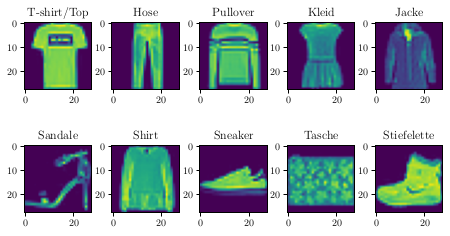

In [1070]:
class_names = ['T-shirt/Top', 'Hose', 'Pullover', 'Kleid', 'Jacke',
               'Sandale', 'Shirt', 'Sneaker', 'Tasche', 'Stiefelette']

fig, axs = plt.subplots(2, 5, figsize=(1.5*5,2*2))
for i in range(len(class_names)):
    ax = axs[i//5, i%5]
    ax.imshow(X_train[Y_train == i][0])
    ax.set_title(class_names[i])
dpi = 300
fig.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('fashion.pdf', format='pdf', bbox_inches='tight')

In [1071]:
ind_train = np.where((Y_train == 1) | (Y_train ==3))[0][:1000]
ind_test = np.where((Y_test == 1) | (Y_test == 3))[0][:400]

In [1072]:
# neu
Y_train = (Y_train !=1).astype(int)
Y_test = (Y_test != 1).astype(int)

In [1073]:
Y_train = Y_train[ind_train]
X_train = X_train[ind_train]

Y_test = Y_test[ind_test]
X_test = X_test[ind_test]

In [1074]:
ind_train0 = np.where((Y_train == 0))[0]
ind_train1 = np.where((Y_train == 1))[0]
ind_test0 = np.where((Y_test == 0))[0]
ind_test1 = np.where((Y_test == 1))[0]

In [1075]:
X_train_org = X_train
X_test_org = X_test

#### reshape data

In [1076]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#### normalize data

In [1077]:
X_train = no().fit_transform(X_train)
X_test = no().fit_transform(X_test)

#### use pca to reduce dimension (784 predictors (pixels) take too much computational time for locpol function)

In [1078]:
pca = PCA(0.6)
pca.fit(X_train,Y_train)
PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,  svd_solver='auto', tol=0.0, whiten=False)
pca.n_components_

10

In [1079]:
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

In [1080]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1000, 10)
(1000,)
(400, 10)
(400,)


#### use locpol package to fit local polynomial regression model to train data, evaluate at test & training data

In [1081]:
etaX_train = localreg(X_train, Y_train,degree=1)

In [1082]:
etaX_test = localreg(X_train, Y_train,X_test,degree=1)

In [1083]:
# pd.DataFrame({'etaX':etaX, 'Y':Y_test})

In [1084]:
t =  Overall(Y_train,etaX_train,0.03)[0]

In [1085]:
Overall(Y_train,etaX_train,0.03)

(0.487711027869417, 0.03, 0.004)

In [1086]:
ind_abs = np.where((etaX_test <= (1-t)) & (etaX_test >= t))[0]
ind0_mis1 = np.where((etaX_test > (1-t)) & (Y_test == 0))[0]
ind1_mis0 = np.where((etaX_test < t) & (Y_test == 1))[0]

In [1087]:
l1 = len(ind_abs)
print(l1)

5


In [1088]:
l2= len(ind0_mis1)
print(l2)

11


In [1089]:
l3 = len(ind1_mis0)
print(l3)

4


In [1090]:
len(ind_abs)/400

0.0125

In [1091]:
(len(ind0_mis1)+len(ind1_mis0))/400

0.0375

In [1092]:
(np.sum((etaX_train > (1-t)) & (Y_train == 0)) + np.sum((etaX_train < t) & (Y_train == 1)))/1000

0.03

In [1093]:
(np.sum((etaX_train <= (1-t)) & (etaX_train >= t)))/1000

0.004

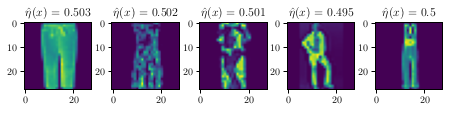

In [1094]:
fig, axs = plt.subplots(1, l1, figsize=(1.5*l1,2))
for i, ind in enumerate(ind_abs):
    ax = axs[i]
    ax.imshow(X_test_org[ind])
    ax.set_title('$\hat\eta(x) = $ ' + str(round(etaX_test[ind],3)))
    #ax.set_xticks([])
    #ax.set_yticks([])
fig.subplots_adjust(wspace=0.3)
#fig.savefig('fashion_abs.pdf', format='pdf', bbox_inches='tight')

# class Specific Coverage

## Diabetes

In [298]:
diab=pd.read_csv("C:/Users/johan/Desktop/Studium/MA/Code/Python/diabetes.csv")

In [299]:
diab.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [300]:
diab = diab[:20000]

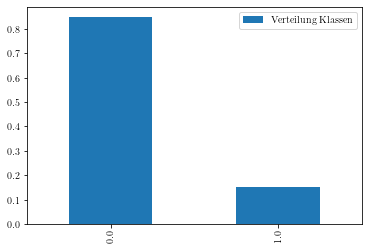

In [321]:
diab["Diabetes_binary"].value_counts(normalize=True).plot(kind='bar', label = 'Verteilung Klassen');
plt.legend()
plt.savefig('labelVert.pgf')

In [322]:
Y = diab[["Diabetes_binary"][0]].to_numpy()
X = diab.drop(['Diabetes_binary'], axis = 1).to_numpy()

In [338]:
X.shape

(20000, 21)

In [339]:
Y.shape

(20000,)

In [341]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, shuffle=True,stratify=Y,random_state=42)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.25,random_state=42)

In [343]:
X_train0 = X_train[np.where(Y_train == 0)[0]]
X_train1 = X_train[np.where(Y_train == 1)[0]]
X_test0 = X_test[np.where(Y_test == 0)[0]]
X_test1 = X_test[np.where(Y_test == 1)[0]]
# X_val0 = X_val[np.where(Y_val == 0)[0]]
# X_val1 = X_val[np.where(Y_val == 1)[0]]

In [345]:
print(X_train0.shape)
print(X_train1.shape)
print(X_test0.shape)
print(X_test1.shape)
# print(X_val0.shape)
# print(X_val1.shape)

(13579, 21)
(2421, 21)
(3395, 21)
(605, 21)


In [347]:
pca0 = PCA(0.9)
pca0.fit(X_train0)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,  svd_solver='auto', tol=0.001, whiten=False)
pca0.n_components_

3

In [348]:
pca1 = PCA(0.9)
pca1.fit(X_train1)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,  svd_solver='auto', tol=0.001, whiten=False)
pca1.n_components_

3

In [349]:
X_train0 = pca0.transform(X_train0)
X_train1 = pca1.transform(X_train1)
X_test0 = pca0.transform(X_test0)
X_test1 = pca1.transform(X_test1)
# X_val0 = pca0.transform(X_val0)
# X_val1 = pca1.transform(X_val1)

In [352]:
p0_est = kde(X_train0.T)
p1_est = kde(X_train1.T)
# p0_est.set_bandwidth(bw_method=1)
# p1_est.set_bandwidth(bw_method=1)
qX0 = p1_est(X_train0.T)/p0_est(X_train0.T)
qX1 = p1_est(X_train1.T)/p0_est(X_train1.T)
qX0_test = p1_est(X_test0.T)/p0_est(X_test0.T)
qX1_test = p1_est(X_test1.T)/p0_est(X_test1.T)
t0 = ClassSpecific(0,qX0,0.1)[0]
t1 = ClassSpecific(1,qX1,0.05)[0]
print('P0(f(X) = 1)' + ' = ' + str(round(np.sum(qX0_test > t0)/len(qX0_test),3)))
print('P1(f(X) = 0)' + ' = ' + str(round(np.sum(qX1_test < t1)/len(qX1_test),3)))
print('P0(f(X) = 0)' + ' = ' + str(round(np.sum(qX0_test < t1)/len(qX0_test),3)))
print('P1(f(X) = 1)' + ' = ' + str(round(np.sum(qX1_test > t0)/len(qX1_test),3)))
print('P0(f(X) = E)' + ' = ' + str(round(np.sum((qX0_test <= t0) & (qX0_test >= t1))/len(qX0_test),3)))
print('P1(f(X) = E)' + ' = ' + str(round(np.sum((qX1_test <= t0) & (qX1_test >= t1))/len(qX1_test),3)))
print('t0 = ' + str(round(t0,5)))
print('t1 = ' + str(round(t1,5)))

P0(f(X) = 1) = 0.112
P1(f(X) = 0) = 0.058
P0(f(X) = 0) = 0.744
P1(f(X) = 1) = 0.845
P0(f(X) = E) = 0.143
P1(f(X) = E) = 0.098
t0 = 0.66998
t1 = 0.34229
